# Try to look at the vessel structure
Can we do some distance transformation magic?

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib_scalebar.scalebar import ScaleBar
import seaborn
import pandas
import platform
import os
import numpy
from tqdm import tqdm_notebook
from itkwidgets import view  # 3d viewer
import skimage
import skimage.morphology
import scipy.stats

In [2]:
# Ignore warnings in the notebook
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Set up figure defaults
plt.rc('image', cmap='gray', interpolation='nearest')  # Display all images in b&w and with 'nearest' interpolation
plt.rcParams['figure.figsize'] = (16, 9)  # Size up figures a bit

In [4]:
# Setup scale bar defaults
plt.rcParams['scalebar.location'] = 'lower right'
plt.rcParams['scalebar.frameon'] = False
plt.rcParams['scalebar.color'] = 'white'

In [5]:
# Display all plots identically
lines = 3
# And then do something like
# plt.subplot(lines, numpy.ceil(len(Data) / float(lines)), c + 1)

In [6]:
# Different locations if running either on Linux or Windows
FastSSD = True
# to speed things up significantly
if 'debian' in platform.dist():
    if FastSSD:
        BasePath = os.path.join(os.sep, 'media', 'habi', 'Fast_SSD')
    else:
        BasePath = os.path.join(os.sep, 'home', 'habi', '1272')
else:
    if FastSSD:
        BasePath = os.path.join('F:\\')
    else:
        BasePath = os.path.join('S:\\')
Root = os.path.join(BasePath, 'Tuebingen', 'Overview')
print('We are loading all the data from %s' % Root)

We are loading all the data from /media/habi/Fast_SSD/Tuebingen/Overview


In [7]:
try:
    Data = pandas.read_pickle(os.path.join(Root, 'TuebingenDataframe.pkl'))
except FileNotFoundError:
    print('\n\nData file not found\n\n')
    print('Please run the "DisplayOverViewScans" notebook to generate it first!\n\n')

In [8]:
from datetime import datetime
print('The data file we use was created on %s'
      % datetime.fromtimestamp(os.stat(os.path.join(Root, 'TuebingenDataframe.pkl')).st_ctime))

The data file we use was created on 2020-02-06 14:32:00.758087


In [9]:
# Convert all reconstructions into a single numpy array and them to disk
# But only do this if we didn't do it already :)
# Partially based on http://stackoverflow.com/a/39195332/323100
# Since we reload/memorymap the stack below, we overwrite the variable with NaN and clear the memory
Data['OutputNameRec'] = [os.path.join(f, sample + '_rec.npy') for f, sample in zip(Data.Folder, Data.Sample)]
# Don't save into the dataframe, or else we won't be able to make it :)
Reconstructions = [numpy.nan for file in Data['OutputNameRec']]
# Do it now
for c, row in Data.iterrows():
    if os.path.exists(row['OutputNameRec']):
        print('%2s/%s: %s: Loading reconstructions from %s' % (c + 1,
                                                               len(Data),
                                                               row['Sample'].rjust(Data['SampleNameLength'].max()),
                                                               row['OutputNameRec']))
        Reconstructions[c] = numpy.load(row['OutputNameRec'], mmap_mode='r')
    else:
        print('%2s/%s: %s: Reading %04s reconstructions' % (c + 1,
                                                            len(Data),
                                                            row['Sample'].rjust(Data['SampleNameLength'].max()),
                                                            row['Number of reconstructions']))
        # https://groups.google.com/forum/#!topic/imageio/O3TjIWKzd5Q
        Reconstructions[c] = numpy.stack([imageio.imread(rec,
                                                         ignoregamma=True) for rec in row['Reconstructions']], 0)
        print('%s: Saving to %s' % (row['Sample'].rjust(Data['SampleNameLength'].max() + 7),
                                    row['OutputNameRec'][len(Root):]))
        numpy.save(row['OutputNameRec'], Reconstructions[c], allow_pickle=False)

 1/14:  04N: Loading reconstructions from /media/habi/Fast_SSD/Tuebingen/Overview/04N/04N_rec.npy
 2/14: 04OP: Loading reconstructions from /media/habi/Fast_SSD/Tuebingen/Overview/04OP/04OP_rec.npy
 3/14:  07N: Loading reconstructions from /media/habi/Fast_SSD/Tuebingen/Overview/07N/07N_rec.npy
 4/14: 07OP: Loading reconstructions from /media/habi/Fast_SSD/Tuebingen/Overview/07OP/07OP_rec.npy
 5/14:  10N: Loading reconstructions from /media/habi/Fast_SSD/Tuebingen/Overview/10N/10N_rec.npy
 6/14: 10OP: Loading reconstructions from /media/habi/Fast_SSD/Tuebingen/Overview/10OP/10OP_rec.npy
 7/14:  14N: Loading reconstructions from /media/habi/Fast_SSD/Tuebingen/Overview/14N/14N_rec.npy
 8/14: 14OP: Loading reconstructions from /media/habi/Fast_SSD/Tuebingen/Overview/14OP/14OP_rec.npy
 9/14:  15N: Loading reconstructions from /media/habi/Fast_SSD/Tuebingen/Overview/15N/15N_rec.npy
10/14: 15OP: Loading reconstructions from /media/habi/Fast_SSD/Tuebingen/Overview/15OP/15OP_rec.npy
11/14:  19

In [10]:
# The three cardinal directions
directions = ['Axial', 'Sagittal', 'Coronal']

In [11]:
Data.head()

index                                        Folder Sample Experiment  \
0      0   /media/habi/Fast_SSD/Tuebingen/Overview/04N    04N          N   
1      1  /media/habi/Fast_SSD/Tuebingen/Overview/04OP   04OP         OP   
2      2   /media/habi/Fast_SSD/Tuebingen/Overview/07N    07N          N   
3      3  /media/habi/Fast_SSD/Tuebingen/Overview/07OP   07OP         OP   
4      4   /media/habi/Fast_SSD/Tuebingen/Overview/10N    10N          N   

   SampleNameLength                                            LogFile  \
0                 3  /media/habi/Fast_SSD/Tuebingen/Overview/04N/pr...   
1                 4  /media/habi/Fast_SSD/Tuebingen/Overview/04OP/p...   
2                 3  /media/habi/Fast_SSD/Tuebingen/Overview/07N/pr...   
3                 4  /media/habi/Fast_SSD/Tuebingen/Overview/07OP/p...   
4                 3  /media/habi/Fast_SSD/Tuebingen/Overview/10N/pr...   

   Voxelsize  NumRec                                    Reconstructions  \
0  21.603999    1767  [/media/habi/Fast_SSD/Tuebingen/Overview/04N/r...   
1  21.603999    1606  [/media/habi/Fast_SSD/Tuebingen/Overview/04OP/...   
2  21.603999    1598  [/media/habi/Fast_SSD/Tuebingen/Overview/07N/r...   
3  21.603999    1753  [/media/habi/Fast_SSD/Tuebingen/Overview/07OP/...   
4  21.603999    1948  [/media/habi/Fast_SSD/Tuebingen/Overview/10N/r...   

   Number of reconstructions  \
0                       1767   
1                       1606   
2                       1598   
3                       1753   
4                       1948   

                                       OutputNameRec                Size  \
0  /media/habi/Fast_SSD/Tuebingen/Overview/04N/04...  (1767, 1224, 1224)   
1  /media/habi/Fast_SSD/Tuebingen/Overview/04OP/0...  (1606, 1224, 1224)   
2  /media/habi/Fast_SSD/Tuebingen/Overview/07N/07...  (1598, 1224, 1224)   
3  /media/habi/Fast_SSD/Tuebingen/Overview/07OP/0...  (1753, 1224, 1224)   
4  /media/habi/Fast_SSD/Tuebingen/Overview/10N/10...  (1948, 1224, 1224)   

                                           Mid_Axial  \
0  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
1  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
2  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
3  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
4  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   

                                        Mid_Sagittal  \
0  [[0, 0, 0, 0, 0, 4, 9, 6, 5, 5, 0, 0, 0, 1, 0,...   
1  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 4, 3, 0, 0,...   
2  [[0, 0, 0, 0, 0, 0, 1, 2, 2, 2, 2, 1, 0, 0, 0,...   
3  [[0, 0, 0, 0, 0, 8, 7, 3, 3, 7, 8, 2, 0, 0, 0,...   
4  [[0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   

                                         Mid_Coronal  \
0  [[0, 0, 0, 0, 0, 0, 0, 1, 3, 5, 5, 4, 0, 0, 0,...   
1  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
2  [[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 2, 2,...   
3  [[0, 0, 0, 0, 0, 3, 5, 6, 8, 6, 0, 0, 0, 0, 0,...   
4  [[0, 0, 0, 0, 10, 13, 17, 16, 15, 13, 18, 27, ...   

                                           MIP_Axial  \
0  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
1  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
2  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
3  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
4  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   

                                        MIP_Sagittal  \
0  [[0, 0, 0, 0, 24, 24, 22, 19, 17, 17, 19, 17, ...   
1  [[0, 0, 0, 0, 0, 3, 4, 4, 5, 5, 5, 4, 5, 4, 5,...   
2  [[0, 0, 0, 0, 0, 3, 3, 4, 3, 4, 5, 4, 3, 3, 3,...   
3  [[0, 0, 0, 0, 0, 13, 12, 11, 12, 15, 14, 11, 9...   
4  [[0, 0, 0, 0, 0, 8, 8, 10, 8, 7, 7, 7, 8, 7, 7...   

                                         MIP_Coronal  GrayValueMean  \
0  [[0, 0, 0, 8, 10, 9, 8, 8, 8, 10, 8, 8, 8, 7, ...       6.401361   
1  [[0, 0, 0, 0, 1, 1, 2, 2, 2, 1, 1, 2, 2, 2, 2,...       6.547351   
2  [[0, 0, 0, 0, 2, 2, 2, 2, 3, 2, 2, 2, 3, 2, 3,...       7.543685   
3  [[0, 0, 0, 0, 12, 21, 25, 39

We need to do a segmentation of the vessels/bones to prepare the datasets for the distance transformation.
Since the datasets are fairls simple, we threshold them (with Otsu thresholding) globally.

In [12]:
# plt.hist(Reconstructions[1][Reconstructions[1]>0].ravel(),
#          bins=64,
#          label='without zero',
#          alpha=0.5,
#          log=True)
# plt.hist(Reconstructions[1].ravel(),
#          bins=64,
#          label='including everything',
#          alpha=0.5,
#          log=True)
# plt.legend()
# plt.xlim([0,255])
# plt.show()

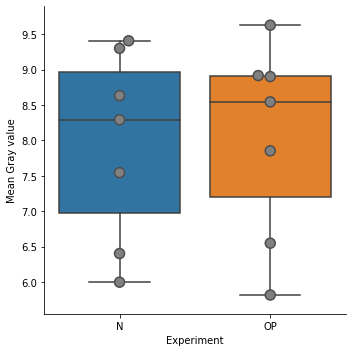

In [13]:
# Plot mean of datasets for comparison
seaborn.catplot(data=Data, kind='box', x='Experiment', y='GrayValueMean')
seaborn.swarmplot(data=Data, x='Experiment', y='GrayValueMean', linewidth=1.5, s=10, color='gray');
plt.ylabel('Mean Gray value')
# plt.ylim(ymin=0)
plt.show()

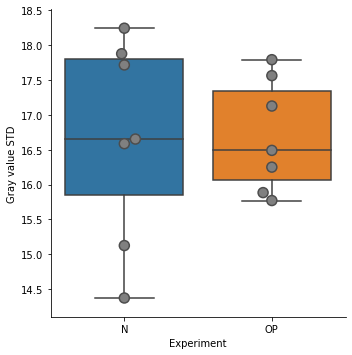

In [14]:
# Plot STD of datasets for comparison
seaborn.catplot(data=Data, kind='box', x='Experiment', y='GrayValueSTD')
seaborn.swarmplot(data=Data, x='Experiment', y='GrayValueSTD', linewidth=1.5, s=10, color='gray');
plt.ylabel('Gray value STD')
# plt.ylim(ymin=0)
plt.show()

In [15]:
def crop_center(img, cubesize=25, verbose=True):
    '''
    Return only the central part of the stack, making our life easier.
    E.g. input a cube size and return a cube with this size from the center of the original image
    '''
    if len(numpy.shape(img)) != 3:
        print('Only works with a 3D stack')
        return()
    if verbose:
        print('The original stack has a size of %s x %s x %s px' % numpy.shape(img))
        print('We return the central %s^3 px' % cubesize)
    if int(numpy.shape(img)[0] - cubesize) < 0 or int(numpy.shape(img)[1] - cubesize) < 0 or int(numpy.shape(img)[2] - cubesize) < 0:
        print(3*'\n')
        print('You need to select a smaller "cubesize" than %s, '
              'otherwise I do not crop the image, but make it bigger' % cubesize)
        print(3*'\n')        
        return(numpy.nan)
    # Based on the given cubesize above we calculate how much we need to cut in the mean from each axis
    img_center = img[int((numpy.shape(img)[0] - cubesize) / 2):-int((numpy.shape(img)[0] - cubesize) / 2),
                     int((numpy.shape(img)[1] - cubesize) / 2):-int((numpy.shape(img)[1] - cubesize) / 2),
                     int((numpy.shape(img)[2] - cubesize) / 2):-int((numpy.shape(img)[2] - cubesize) / 2)]
    return(img_center)

In [16]:
def calculate_threshold(img, verbose=True):
    '''
    Calculate (Otsu) threshold of a stack, with some nice output if desired
    '''
    if len(numpy.shape(img)) != 3:
        print('Only works with a 3D stack')
        return()
    if verbose:
        print('The stack we use has a size of %s x %s x %s px' % numpy.shape(img))
    threshold = skimage.filters.threshold_otsu(img[img>numpy.mean(img)].ravel())
    if verbose:
        seaborn.distplot(img.ravel())
        plt.axvline(threshold, label='Otsu@%s' % threshold, c=seaborn.color_palette()[1])
        plt.axvline(numpy.mean(img), label='Image mean@%0.2f' % numpy.mean(img), c=seaborn.color_palette()[2])
        plt.legend()
        plt.semilogy()
        plt.xlim([0,255])
        plt.show()
    return(threshold)

In [17]:
# Calculate Otsu threshold for *all* the reconstructions and save them to the dataframe
# We can either calculate the threshold on only the central part or the full dataset.
# Subsequently, we apply the threshold to the full datasets.
cubesize=750
onlycentralpart = True
if onlycentralpart:
    Data['Threshold'] = [calculate_threshold(crop_center(rec,
                                                         cubesize=cubesize,
                                                         verbose=False),
                                             verbose=False) for rec in Reconstructions]
else:
    Data['Threshold'] = [calculate_threshold(rec,
                                             verbose=False) for rec in Reconstructions]

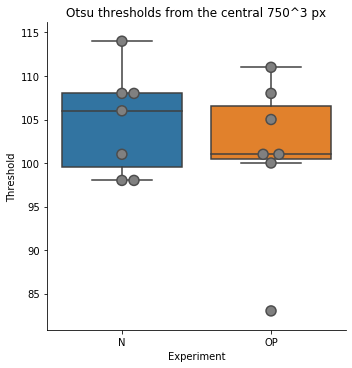

The mean threshold of all samples is 103.00


In [18]:
# Plot the thresholds
seaborn.catplot(data=Data, kind='box', x='Experiment', y='Threshold')
seaborn.swarmplot(data=Data, x='Experiment', y='Threshold', linewidth=1.5, s=10, color='gray');
# plt.ylim([0,255])
plt.title('Otsu thresholds from the central %s^3 px' % cubesize)
plt.show()
print('The mean threshold of all samples is %0.2f' % Data['Threshold'].mean())

In [19]:
# Get the mean threshold of all samples
Data['ThresholdMean'] = int(numpy.mean(Data['Threshold'].mean()))

In [20]:
# Threshold the reconstructions, save as new dataset and load them into variable
Data['OutputNameThresholded'] = [os.path.join(f,
                                              '%s_rec_thresholded_%03d.npy' % (sample, threshold))
                                 for f, sample, threshold in zip(Data.Folder,
                                                                 Data.Sample,
                                                                 Data.Threshold)]
Thresholded = [numpy.nan for file in Data['OutputNameThresholded']]
for c, row in Data.iterrows():
    if os.path.exists(row['OutputNameThresholded']):
        print('%2s/%s: %s: Loading thresholded dataset %s' % (c + 1,
                                                              len(Data),
                                                              row['Sample'].rjust(Data['SampleNameLength'].max()),
                                                              row['OutputNameThresholded'][len(Root):]))
        Thresholded[c] = numpy.load(row['OutputNameThresholded'], mmap_mode='r')
    else:
        print('%2s/%s: %s: Thresholding reconstructions with %s' % (c + 1,
                                                                    len(Data),
                                                                    row['Sample'].rjust(Data['SampleNameLength'].max()),
                                                                    row['Threshold']))
        Thresholded[c] = Reconstructions[c] > row['Threshold']
        print('%s: Saving to %s' % (row['Sample'].rjust(Data['SampleNameLength'].max() + 7),
                                    row['OutputNameThresholded'][len(Root):]))
        numpy.save(row['OutputNameThresholded'], Thresholded[c], allow_pickle=False)

 1/14:  04N: Thresholding reconstructions with 98
        04N: Saving to /04N/04N_rec_thresholded_098.npy
 2/14: 04OP: Loading thresholded dataset /04OP/04OP_rec_thresholded_101.npy
 3/14:  07N: Loading thresholded dataset /07N/07N_rec_thresholded_106.npy
 4/14: 07OP: Loading thresholded dataset /07OP/07OP_rec_thresholded_101.npy
 5/14:  10N: Loading thresholded dataset /10N/10N_rec_thresholded_108.npy
 6/14: 10OP: Thresholding reconstructions with 83
       10OP: Saving to /10OP/10OP_rec_thresholded_083.npy
 7/14:  14N: Thresholding reconstructions with 98
        14N: Saving to /14N/14N_rec_thresholded_098.npy
 8/14: 14OP: Loading thresholded dataset /14OP/14OP_rec_thresholded_100.npy
 9/14:  15N: Loading thresholded dataset /15N/15N_rec_thresholded_114.npy
10/14: 15OP: Loading thresholded dataset /15OP/15OP_rec_thresholded_111.npy
11/14:  19N: Loading thresholded dataset /19N/19N_rec_thresholded_108.npy
12/14: 19OP: Loading thresholded dataset /19OP/19OP_rec_thresholded_105.npy
13/1

In [21]:
# Sum the images, so we can see if they contain approximately the same volume
Data['ThresholdedVolume'] = [numpy.sum(th) for th in Thresholded]

In [22]:
Data[['Sample', 'ThresholdedVolume']]

Sample  ThresholdedVolume
0     04N            7650455
1    04OP            7371814
2     07N            6868607
3    07OP            6868509
4     10N            8943517
5    10OP           21323504
6     14N            6548149
7    14OP           10815798
8     15N            8324328
9    15OP            9116549
10    19N            7631281
11   19OP            9539235
12    22N           14411016
13   22OP            7539206

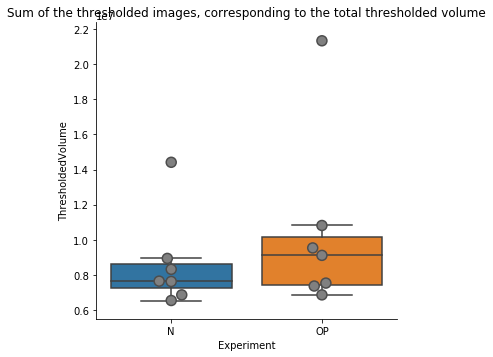

In [23]:
# Plot the thresholded volumes
seaborn.catplot(data=Data, kind='box', x='Experiment', y='ThresholdedVolume')
seaborn.swarmplot(data=Data, x='Experiment', y='ThresholdedVolume', linewidth=1.5, s=10, color='gray');
# plt.ylim([0,255])
plt.title('Sum of the thresholded images, corresponding to the total thresholded volume')
plt.show()

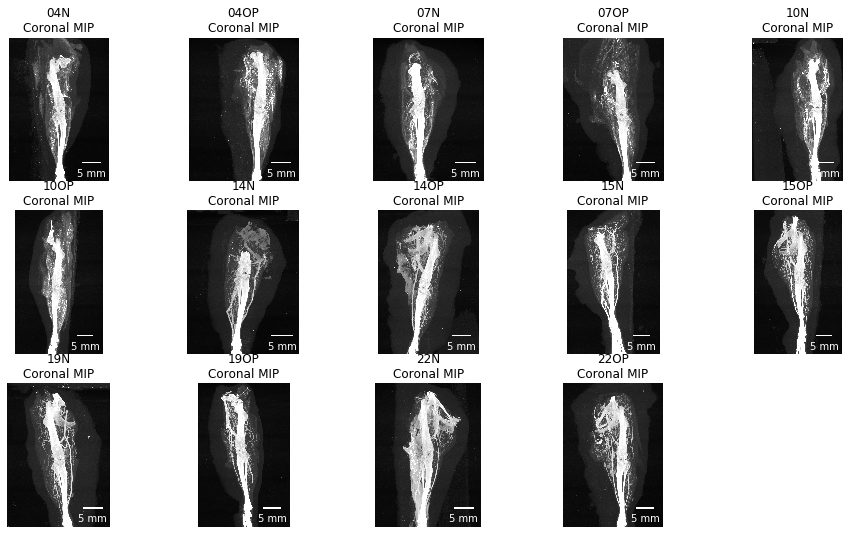

In [24]:
for c,row in Data.iterrows():
    plt.subplot(lines, numpy.ceil(len(Data) / float(lines)), c + 1)
    plt.imshow(row.MIP_Coronal)
    plt.title('%s\nCoronal MIP' % Data['Sample'][c])
    plt.gca().add_artist(ScaleBar(Data['Voxelsize'][c], 'um'))    
    plt.axis('off')
plt.show()

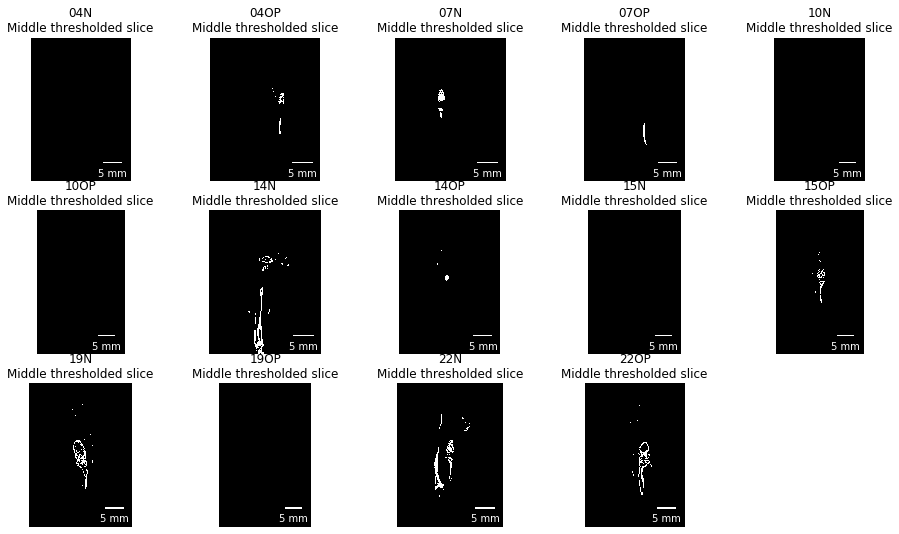

In [25]:
for c,t in enumerate(Thresholded):
    plt.subplot(lines, numpy.ceil(len(Data) / float(lines)), c + 1)
    plt.imshow(t[:,:,len(t)//2])
    plt.title('%s\nMiddle thresholded slice' % Data['Sample'][c])
    plt.gca().add_artist(ScaleBar(Data['Voxelsize'][c], 'um'))    
    plt.axis('off')
plt.show()

In [26]:
view(Thresholded[0].astype('uint8'))

Viewer(geometries=[], gradient_opacity=0.22, point_sets=[], rendered_image=<itkImagePython.itkImageUC3; proxy …

# Characterization of vessel diameter
- Fill the bones (with something like `skimage.fill.small.holes`)
    This doesn't seem to be working in the 3D case (maybe because of small holes in the bone) but we just loop through every slice and do it for each and everyone of it. This is bad code, but works :)
- Remove all the bones (with `tophat`), or remove all the big stuff from the segmentation (how big?)
- Calculate the distance-transformation or skeleton

In [27]:
def ourfiller(image, verbose=False):
    '''
    Since we cannot seem to get remove_small_holes to work in 3D, we simply brute-force it on every slice.
    Thanks to `tqdm_notebook` we also get a progress bar...
    And afterwards generate an output array.
    '''
    filled = numpy.asarray(
        [skimage.morphology.remove_small_holes(s,
                                               area_threshold=1e4) for s in tqdm_notebook(image,
                                                                                          leave=False)])
    if verbose:
        plt.subplot(131)
        plt.imshow(image[len(filled)//2,:,:])
        plt.title('Original')
        plt.subplot(132)
        plt.imshow(filled[len(filled)//2,:,:])       
        plt.title('Filled (output)')
        plt.subplot(133)        
        plt.imshow(image[len(filled)//2,:,:], alpha=0.5)       
        plt.imshow(filled[len(filled)//2,:,:], cmap='viridis', alpha=0.5)       
        plt.title('Overlay')        
        plt.show()    
    return(filled)

In [28]:
# def pad_edges(image, howmanypixels=25):
#     '''There *has* to be a better way to set the edges to one, but I havent found one'''
#     closed = image.copy()
#     closed[:howmanypixels,:,:] = True
#     closed[:,:howmanypixels,:] = True
#     closed[:,:,:howmanypixels] = True
#     closed[-howmanypixels:,:,:] = True
#     closed[:,-howmanypixels:,:] = True
#     closed[:,:,-howmanypixels:] = True
#     return(closed)

In [29]:
# def fill_hollow_bones(image, verbose=False):
#     '''
#     We flood-fill the image from one edge.
#     Then we add the inversion of this to the original image and thus filled all the long bones.
#     '''
#     dilated = skimage.morphology.binary_dilation(
#         skimage.morphology.binary_dilation(
#             skimage.morphology.binary_dilation(image)))
#     closed = pad_edges(dilated)
#     # Flood fill from one edge and invert the (boolean) result
#     flooded = ~skimage.morphology.flood_fill(closed.astype('int'),
#                                              seed_point=(30,30,30),
#                                              new_value=1).astype('bool')
#     # Add the inverted result to the original image, filling the long bones
#     filled = numpy.add(image, skimage.morphology.binary_dilation(
#         skimage.morphology.binary_dilation(
#             skimage.morphology.binary_dilation(flooded))))
#     if verbose:
#         plt.subplot(131)
#         plt.imshow(image[len(filled)//2,:,:])
#         plt.title('original')
#         plt.subplot(132)
#         plt.imshow(flooded[len(filled)//2,:,:])       
#         plt.title('flooded')
#         plt.subplot(133)        
#         plt.imshow(image[len(filled)//2,:,:], alpha=0.5)       
#         plt.imshow(filled[len(filled)//2,:,:], cmap='viridis', alpha=0.5)       
#         plt.title('filled (output)')        
#         plt.show()
#     return(filled)

In [30]:
# Calculate the flood-filled image
# Since this takes a while, we don't do it in a Pythonic way
# e.g. (Flooded = [ourfiller(t, verbose=True) for t in Tresholded])
# but in a loop with saving in between.
Data['OutputNameFlooded'] = [f.replace('.npy', '_flooded.npy') for f in Data['OutputNameThresholded']]
Flooded = [numpy.nan for file in Data['OutputNameFlooded']]
for c, row in Data.iterrows():
    if os.path.exists(row['OutputNameFlooded']):
        print('%2s/%s: %s: Loading filled dataset %s' % (c + 1,
                                                         len(Data),
                                                         row['Sample'].rjust(Data['SampleNameLength'].max()),
                                                         row['OutputNameFlooded'][len(Root):]))
        Flooded[c] = numpy.load(row['OutputNameFlooded'], mmap_mode='r')
    else:
        print('%2s/%s: %s: Filling holes' % (c + 1,
                                             len(Data),
                                             row['Sample'].rjust(Data['SampleNameLength'].max())))
        Flooded[c] = ourfiller(Thresholded[c])
        print('%s: Saving to %s' % (row['Sample'].rjust(Data['SampleNameLength'].max() + 7),
                                    row['OutputNameFlooded'][len(Root):]))
        numpy.save(row['OutputNameFlooded'],
                   Flooded[c],
                   allow_pickle=False)

 1/14:  04N: Loading filled dataset /04N/04N_rec_thresholded_098_flooded.npy
 2/14: 04OP: Loading filled dataset /04OP/04OP_rec_thresholded_101_flooded.npy
 3/14:  07N: Loading filled dataset /07N/07N_rec_thresholded_106_flooded.npy
 4/14: 07OP: Loading filled dataset /07OP/07OP_rec_thresholded_101_flooded.npy
 5/14:  10N: Loading filled dataset /10N/10N_rec_thresholded_108_flooded.npy
 6/14: 10OP: Loading filled dataset /10OP/10OP_rec_thresholded_083_flooded.npy
 7/14:  14N: Loading filled dataset /14N/14N_rec_thresholded_098_flooded.npy
 8/14: 14OP: Loading filled dataset /14OP/14OP_rec_thresholded_100_flooded.npy
 9/14:  15N: Loading filled dataset /15N/15N_rec_thresholded_114_flooded.npy
10/14: 15OP: Loading filled dataset /15OP/15OP_rec_thresholded_111_flooded.npy
11/14:  19N: Loading filled dataset /19N/19N_rec_thresholded_108_flooded.npy
12/14: 19OP: Loading filled dataset /19OP/19OP_rec_thresholded_105_flooded.npy
13/14:  22N: Loading filled dataset /22N/22N_rec_thresholded_101

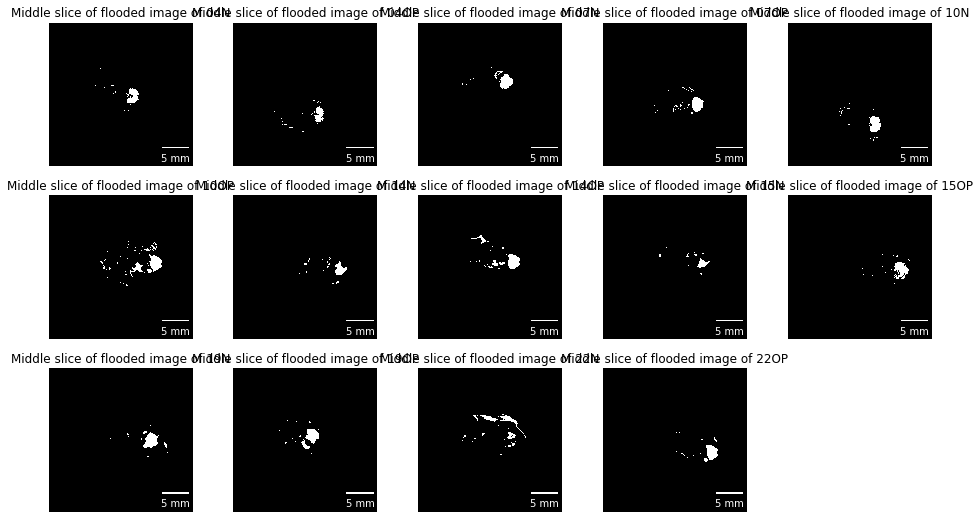

In [31]:
for c,f in enumerate(Flooded):
    plt.subplot(lines, numpy.ceil(len(Data) / float(lines)), c + 1)
    plt.imshow(f[len(f)//2,:,:])
    plt.title('Middle slice of flooded image of %s' % Data['Sample'][c])
    plt.gca().add_artist(ScaleBar(Data['Voxelsize'][c], 'um'))    
    plt.axis('off')
plt.show()

In [32]:
# Get the white tophat
# https://scikit-image.org/docs/dev/api/skimage.morphology.html#skimage.morphology.white_tophat
# e.g. the bright spots of the image that are smaller than the structuring element.
# We use a ball-shaped (sphere) structuring element
# Again, since this takes a *long* while, we don't do it nice and pythonic,
# but in a loop with intermediate saving
# e.g. not (Tophat = [skimage.morphology.white_tophat(f, selem=skimage.morphology.ball(7)) for f in Flooded])
# but
Data['OutputNameTophat'] = [f.replace('.npy', '_tophat.npy') for f in Data['OutputNameFlooded']]
Tophat = [numpy.nan for file in Data['OutputNameTophat']]
for c, row in Data.iterrows():
    if os.path.exists(row['OutputNameTophat']):
        print('%2s/%s: %s: Loading tophat-filtered dataset %s' % (c + 1,
                                                                  len(Data),
                                                                  row['Sample'].rjust(Data['SampleNameLength'].max()),
                                                                  row['OutputNameTophat'][len(Root):]))
        Tophat[c] = numpy.load(row['OutputNameTophat'], mmap_mode='r')
    else:
        print('%2s/%s: %s: Calculating white tophat' % (c + 1,
                                                        len(Data),
                                                        row['Sample'].rjust(Data['SampleNameLength'].max())))
        Tophat[c] = skimage.morphology.white_tophat(Flooded[c],
                                                    selem=skimage.morphology.ball(7))
        print('%s: Saving to %s' % (row['Sample'].rjust(Data['SampleNameLength'].max() + 7),
                                    row['OutputNameTophat'][len(Root):]))
        numpy.save(row['OutputNameTophat'],
                   Tophat[c],
                   allow_pickle=False)

 1/14:  04N: Loading tophat-filtered dataset /04N/04N_rec_thresholded_098_flooded_tophat.npy
 2/14: 04OP: Loading tophat-filtered dataset /04OP/04OP_rec_thresholded_101_flooded_tophat.npy
 3/14:  07N: Loading tophat-filtered dataset /07N/07N_rec_thresholded_106_flooded_tophat.npy
 4/14: 07OP: Loading tophat-filtered dataset /07OP/07OP_rec_thresholded_101_flooded_tophat.npy
 5/14:  10N: Loading tophat-filtered dataset /10N/10N_rec_thresholded_108_flooded_tophat.npy
 6/14: 10OP: Loading tophat-filtered dataset /10OP/10OP_rec_thresholded_083_flooded_tophat.npy
 7/14:  14N: Loading tophat-filtered dataset /14N/14N_rec_thresholded_098_flooded_tophat.npy
 8/14: 14OP: Loading tophat-filtered dataset /14OP/14OP_rec_thresholded_100_flooded_tophat.npy
 9/14:  15N: Loading tophat-filtered dataset /15N/15N_rec_thresholded_114_flooded_tophat.npy
10/14: 15OP: Loading tophat-filtered dataset /15OP/15OP_rec_thresholded_111_flooded_tophat.npy
11/14:  19N: Loading tophat-filtered dataset /19N/19N_rec_th

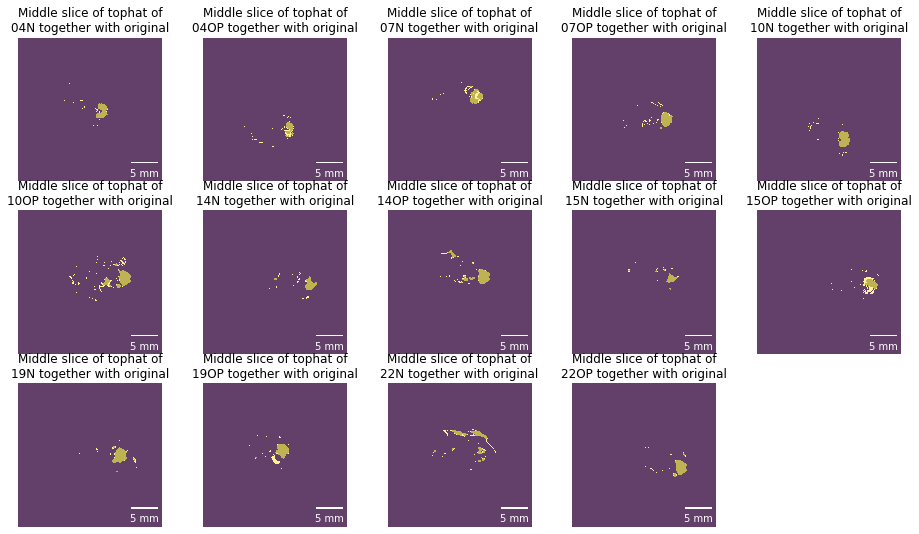

In [33]:
for c,t in enumerate(Tophat):
    plt.subplot(lines, numpy.ceil(len(Data) / float(lines)), c + 1)    
    plt.imshow(t[len(t)//2,:,:], alpha=0.5)
    plt.imshow(Flooded[c][len(Flooded[c])//2,:,:], alpha=0.5, cmap='viridis')
    plt.title('Middle slice of tophat of\n%s together with original' % Data['Sample'][c])
    plt.gca().add_artist(ScaleBar(Data['Voxelsize'][c], 'um'))    
    plt.axis('off')
plt.show()

In [34]:
# Show overlay
# for c, direction in enumerate(directions):
#     print(c, direction)    
#     if c:
#         plt.imshow(numpy.rot90(center, axes=(0,c))[len(flooded)//2,:,:], alpha=0.33)
#         plt.imshow(numpy.rot90(flooded, axes=(0,c))[len(flooded)//2,:,:], alpha=0.33, cmap='magma')
#         plt.imshow(numpy.rot90(tophat, axes=(0,c))[len(flooded)//2,:,:], alpha=0.33, cmap='viridis')
#     else:
#         plt.imshow(center[len(flooded)//2,:,:], alpha=0.33)
#         plt.imshow(flooded[len(flooded)//2,:,:], alpha=0.33, cmap='magma')
#         plt.imshow(tophat[len(flooded)//2,:,:], alpha=0.33, cmap='viridis')
#     plt.gca().add_artist(ScaleBar(Data['Voxelsize'][0], 'um'))
#     plt.axis('off')
#     plt.savefig('Overlay-%s.png' % direction, bbox_inches='tight')  
#     plt.show()

In [35]:
# Calculate the skeletonization (and the EDT in the cell below)
# By multiplying them later on we get a color-coded medial axis transformation
# This conforms to what we would expect from 'skimage.morphology.medial_axis(image, return_distance=True)' which does *not* work for 3D images
Data['OutputNameSkeleton'] = [f.replace('.npy', '_skeleton.npy') for f in Data['OutputNameTophat']]
Skeleton = [numpy.nan for file in Data['OutputNameSkeleton']]
# Calculate skeleton
for c, row in Data.iterrows():
    if os.path.exists(row['OutputNameSkeleton']):
        print('%2s/%s: %s: Loading skeletonized dataset %s' % (c + 1,
                                                               len(Data),
                                                               row['Sample'].rjust(Data['SampleNameLength'].max()),
                                                               row['OutputNameSkeleton'][len(Root):]))
        Skeleton[c] = numpy.load(row['OutputNameSkeleton'], mmap_mode='r')
    else:
        print('%2s/%s: %s: Calculating skeletonization' % (c + 1,
                                                           len(Data),
                                                           row['Sample'].rjust(Data['SampleNameLength'].max())))
        Skeleton[c] = skimage.morphology.skeletonize_3d(Tophat[c])
        print('%s: Saving to %s' % (row['Sample'].rjust(Data['SampleNameLength'].max() + 7),
                                    row['OutputNameSkeleton'][len(Root):]))
        numpy.save(row['OutputNameSkeleton'],
                   Skeleton[c],
                   allow_pickle=False)

 1/14:  04N: Loading skeletonized dataset /04N/04N_rec_thresholded_098_flooded_tophat_skeleton.npy
 2/14: 04OP: Loading skeletonized dataset /04OP/04OP_rec_thresholded_101_flooded_tophat_skeleton.npy
 3/14:  07N: Loading skeletonized dataset /07N/07N_rec_thresholded_106_flooded_tophat_skeleton.npy
 4/14: 07OP: Loading skeletonized dataset /07OP/07OP_rec_thresholded_101_flooded_tophat_skeleton.npy
 5/14:  10N: Loading skeletonized dataset /10N/10N_rec_thresholded_108_flooded_tophat_skeleton.npy
 6/14: 10OP: Loading skeletonized dataset /10OP/10OP_rec_thresholded_083_flooded_tophat_skeleton.npy
 7/14:  14N: Loading skeletonized dataset /14N/14N_rec_thresholded_098_flooded_tophat_skeleton.npy
 8/14: 14OP: Loading skeletonized dataset /14OP/14OP_rec_thresholded_100_flooded_tophat_skeleton.npy
 9/14:  15N: Loading skeletonized dataset /15N/15N_rec_thresholded_114_flooded_tophat_skeleton.npy
10/14: 15OP: Loading skeletonized dataset /15OP/15OP_rec_thresholded_111_flooded_tophat_skeleton.npy


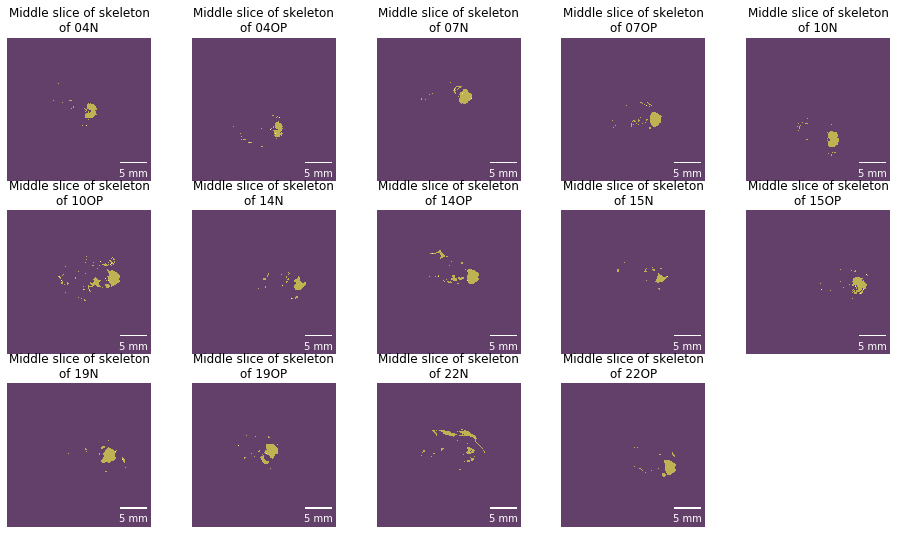

In [36]:
for c,skel in enumerate(Skeleton):
    plt.subplot(lines, numpy.ceil(len(Data) / float(lines)), c + 1)    
    plt.imshow(skel[len(skel)//2,:,:], alpha=0.5)
    plt.imshow(Flooded[c][len(Flooded[c])//2,:,:], alpha=0.5, cmap='viridis')
    plt.title('Middle slice of skeleton\nof %s' % Data['Sample'][c])
    plt.gca().add_artist(ScaleBar(Data['Voxelsize'][c], 'um'))    
    plt.axis('off')
plt.show()

In [37]:
# Calculate the euclidean distance transformation
Data['OutputNameEDT'] = [f.replace('.npy', '_edt.npy') for f in Data['OutputNameTophat']]
EDT = [numpy.nan for file in Data['OutputNameEDT']]
# Calculate edt
for c, row in Data.iterrows():
    if os.path.exists(row['OutputNameEDT']):
        print('%2s/%s: %s: Loading euclidean distance '
              'transformation %s' % (c + 1,
                                     len(Data),
                                     row['Sample'].rjust(Data['SampleNameLength'].max()),
                                     row['OutputNameEDT'][len(Root):]))
        EDT[c] = numpy.load(row['OutputNameEDT'], mmap_mode='r')
    else:
        print('%2s/%s: %s: Calculating euclidean distance transformation' % (c + 1,
                                                                             len(Data),
                                                                             row['Sample'].rjust(Data['SampleNameLength'].max())))
        EDT[c] = scipy.ndimage.morphology.distance_transform_edt(Tophat[c])
        print('%s: Saving to %s' % (row['Sample'].rjust(Data['SampleNameLength'].max() + 7),
                                    row['OutputNameEDT'][len(Root):]))
        numpy.save(row['OutputNameEDT'],
                   EDT[c],
                   allow_pickle=False)

 1/14:  04N: Loading euclidean distance transformation /04N/04N_rec_thresholded_098_flooded_tophat_edt.npy
 2/14: 04OP: Loading euclidean distance transformation /04OP/04OP_rec_thresholded_101_flooded_tophat_edt.npy
 3/14:  07N: Loading euclidean distance transformation /07N/07N_rec_thresholded_106_flooded_tophat_edt.npy
 4/14: 07OP: Loading euclidean distance transformation /07OP/07OP_rec_thresholded_101_flooded_tophat_edt.npy
 5/14:  10N: Loading euclidean distance transformation /10N/10N_rec_thresholded_108_flooded_tophat_edt.npy
 6/14: 10OP: Loading euclidean distance transformation /10OP/10OP_rec_thresholded_083_flooded_tophat_edt.npy
 7/14:  14N: Loading euclidean distance transformation /14N/14N_rec_thresholded_098_flooded_tophat_edt.npy
 8/14: 14OP: Loading euclidean distance transformation /14OP/14OP_rec_thresholded_100_flooded_tophat_edt.npy
 9/14:  15N: Loading euclidean distance transformation /15N/15N_rec_thresholded_114_flooded_tophat_edt.npy
10/14: 15OP: Loading euclidea

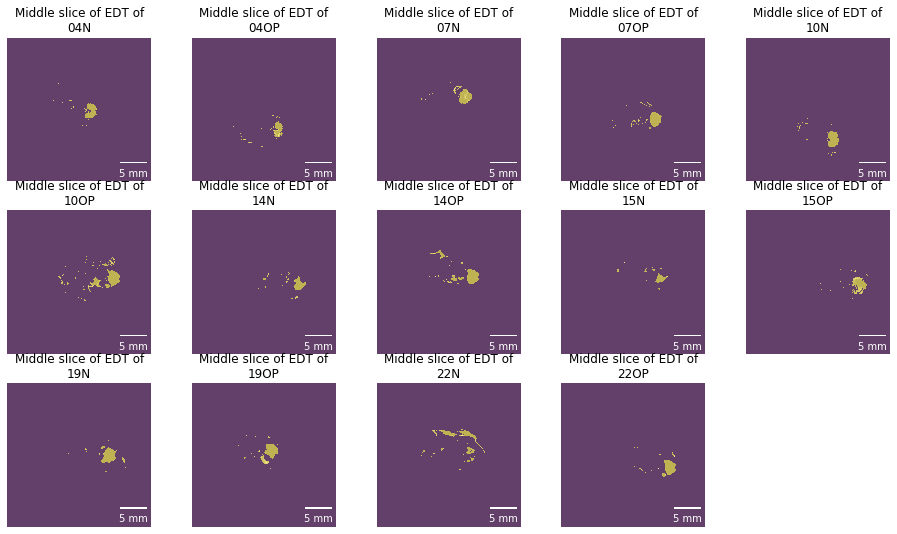

In [38]:
for c,edt in enumerate(EDT):
    plt.subplot(lines, numpy.ceil(len(Data) / float(lines)), c + 1)    
    plt.imshow(edt[len(edt)//2,:,:], alpha=0.5)
    plt.imshow(Flooded[c][len(Flooded[c])//2,:,:], alpha=0.5, cmap='viridis')
    plt.title('Middle slice of EDT of\n%s' % Data['Sample'][c])
    plt.gca().add_artist(ScaleBar(Data['Voxelsize'][c], 'um'))    
    plt.axis('off')
plt.show()

In [39]:
# Show distance on skeleton
Data['OutputNameSkelDist'] = [f.replace('.npy', '_skeletondistance.npy') for f in Data['OutputNameTophat']]
SkelDist = [numpy.nan for file in Data['OutputNameSkelDist']]
# Calculate edt
for c, row in Data.iterrows():
    if os.path.exists(row['OutputNameSkelDist']):
        print('%2s/%s: %s: Loading medial axis distance %s' % (c + 1,
                                                               len(Data),
                                                               row['Sample'].rjust(Data['SampleNameLength'].max()),
                                                               row['OutputNameSkelDist']))
        SkelDist[c] = numpy.load(row['OutputNameSkelDist'], mmap_mode='r')
    else:
        print('%2s/%s: %s: Multiplying skeleton and edt' % (c + 1,
                                                            len(Data),
                                                            row['Sample'].rjust(Data['SampleNameLength'].max())))
        SkelDist[c] = Skeleton[c] * EDT[c]
        print('%s: Saving to %s' % (row['Sample'].rjust(Data['SampleNameLength'].max() + 7),
                                    row['OutputNameSkelDist'][len(Root):]))
        numpy.save(row['OutputNameSkelDist'],
                   SkelDist[c],
                   allow_pickle=False)

 1/14:  04N: Loading medial axis distance /media/habi/Fast_SSD/Tuebingen/Overview/04N/04N_rec_thresholded_098_flooded_tophat_skeletondistance.npy
 2/14: 04OP: Loading medial axis distance /media/habi/Fast_SSD/Tuebingen/Overview/04OP/04OP_rec_thresholded_101_flooded_tophat_skeletondistance.npy
 3/14:  07N: Loading medial axis distance /media/habi/Fast_SSD/Tuebingen/Overview/07N/07N_rec_thresholded_106_flooded_tophat_skeletondistance.npy
 4/14: 07OP: Loading medial axis distance /media/habi/Fast_SSD/Tuebingen/Overview/07OP/07OP_rec_thresholded_101_flooded_tophat_skeletondistance.npy
 5/14:  10N: Loading medial axis distance /media/habi/Fast_SSD/Tuebingen/Overview/10N/10N_rec_thresholded_108_flooded_tophat_skeletondistance.npy
 6/14: 10OP: Loading medial axis distance /media/habi/Fast_SSD/Tuebingen/Overview/10OP/10OP_rec_thresholded_083_flooded_tophat_skeletondistance.npy
 7/14:  14N: Loading medial axis distance /media/habi/Fast_SSD/Tuebingen/Overview/14N/14N_rec_thresholded_098_flooded_

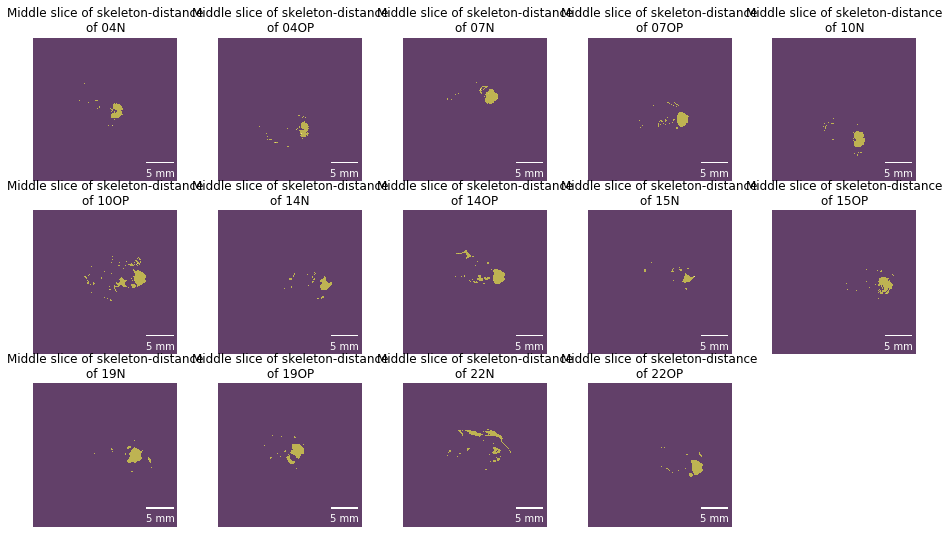

In [40]:
for c,skldst in enumerate(SkelDist):
    plt.subplot(lines, numpy.ceil(len(Data) / float(lines)), c + 1)    
    plt.imshow(skldst[len(skldst)//2,:,:], alpha=0.5)
    plt.imshow(Flooded[c][len(Flooded[c])//2,:,:], alpha=0.5, cmap='viridis')
    plt.title('Middle slice of skeleton-distance\nof %s' % Data['Sample'][c])
    plt.gca().add_artist(ScaleBar(Data['Voxelsize'][c], 'um'))    
    plt.axis('off')
plt.show()

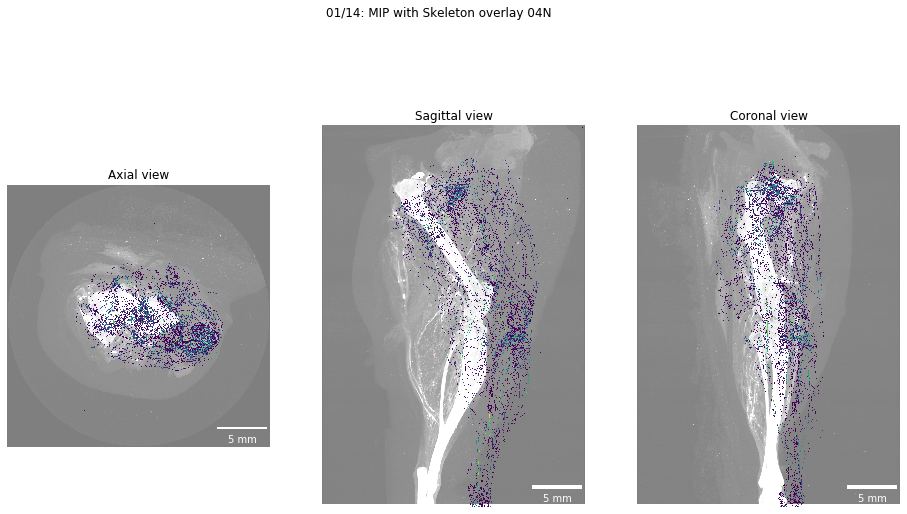

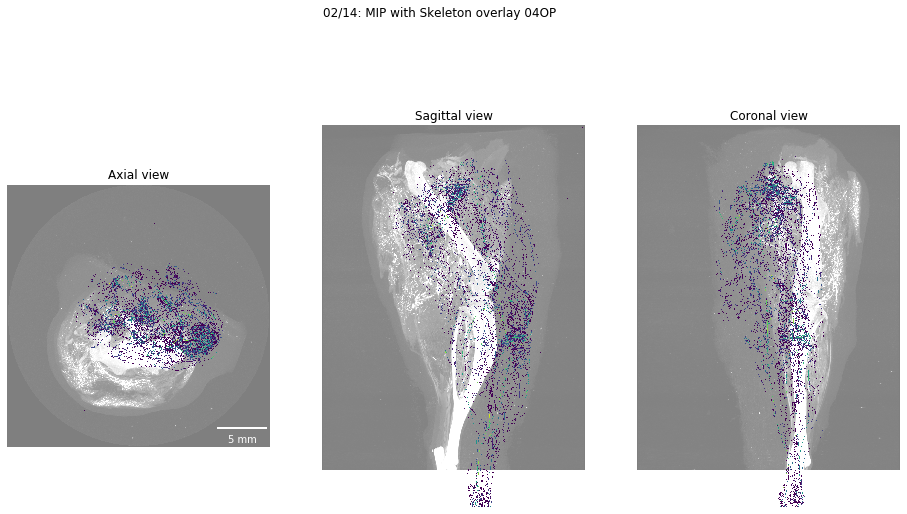

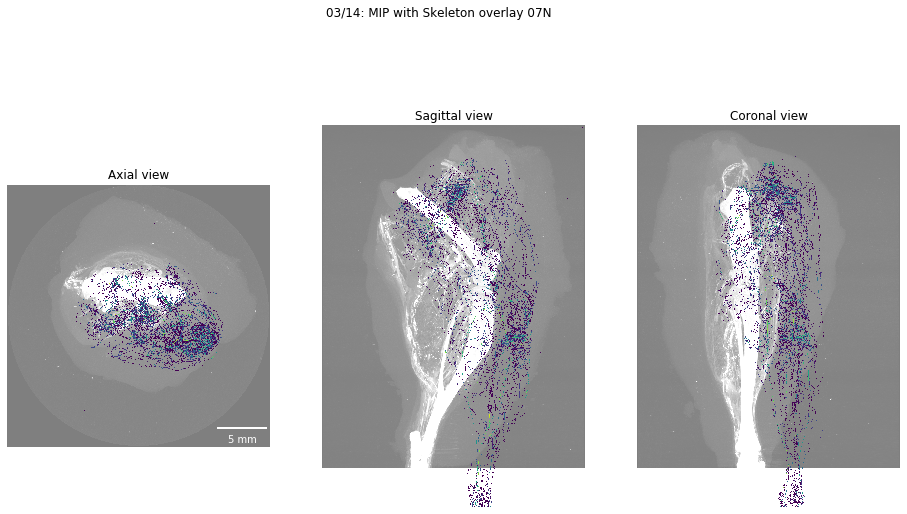

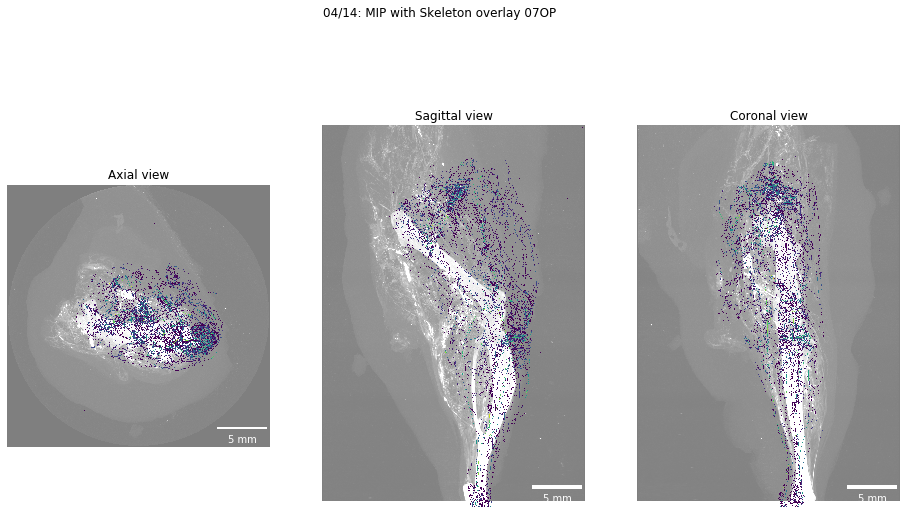

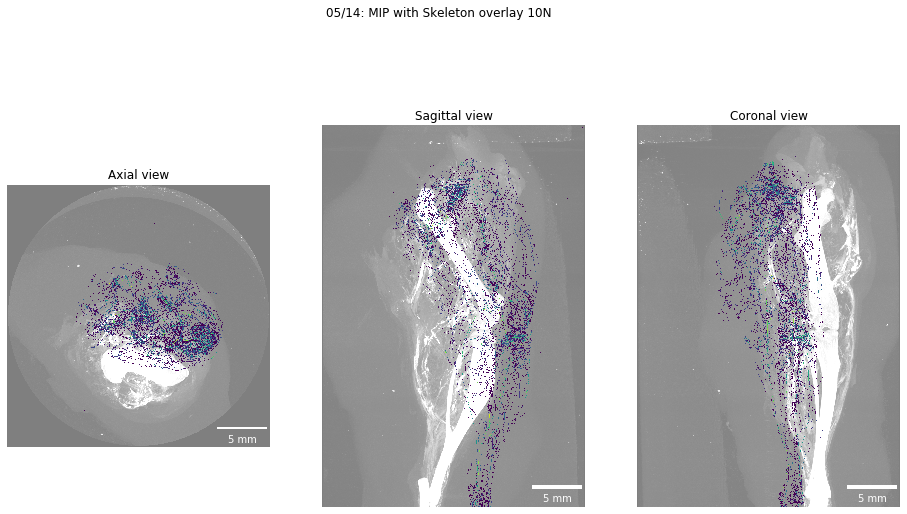

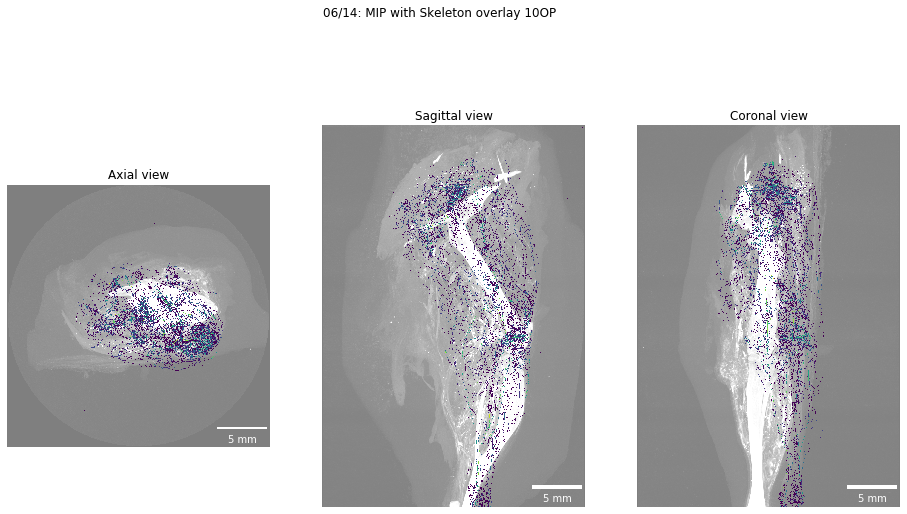

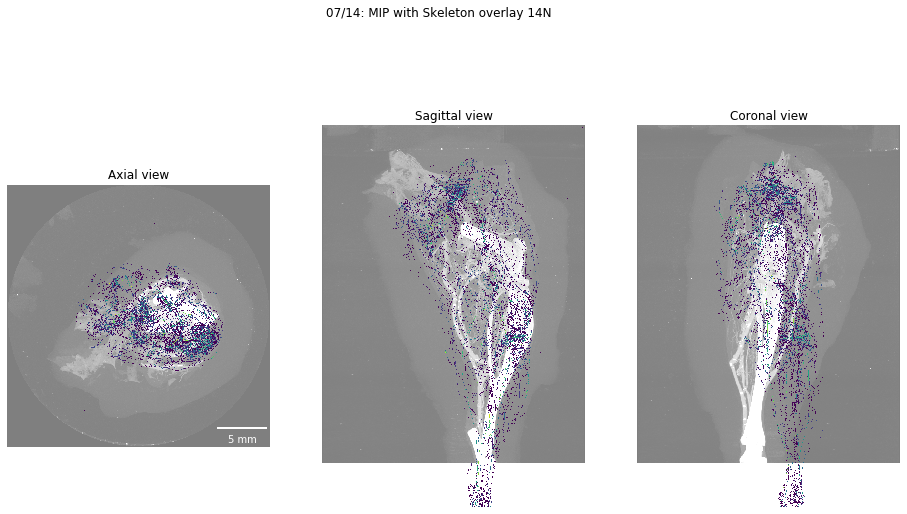

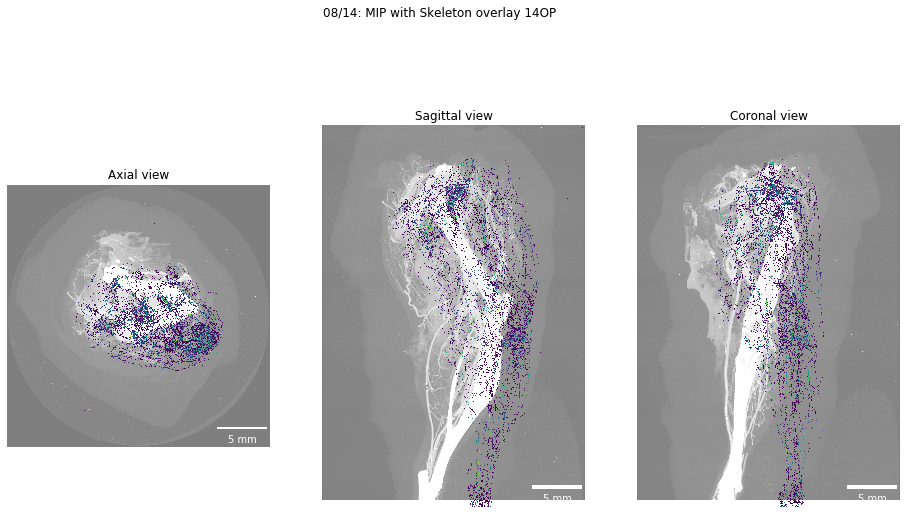

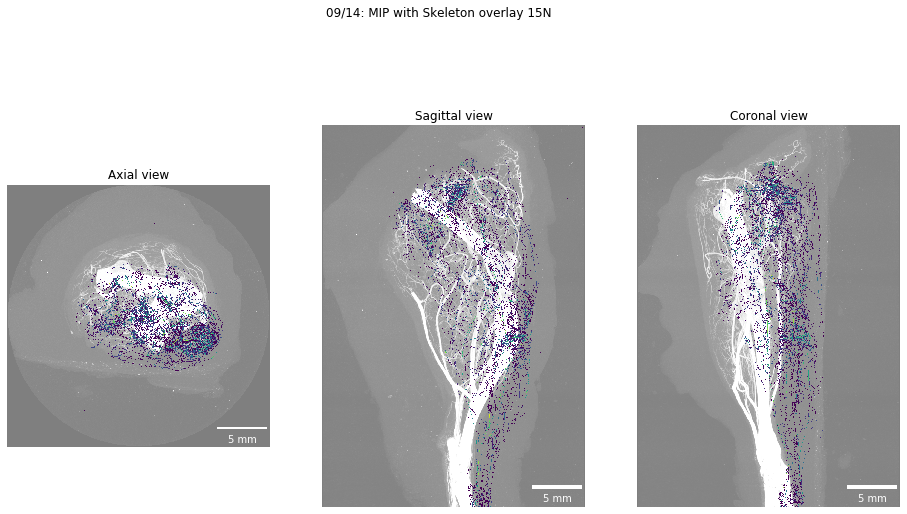

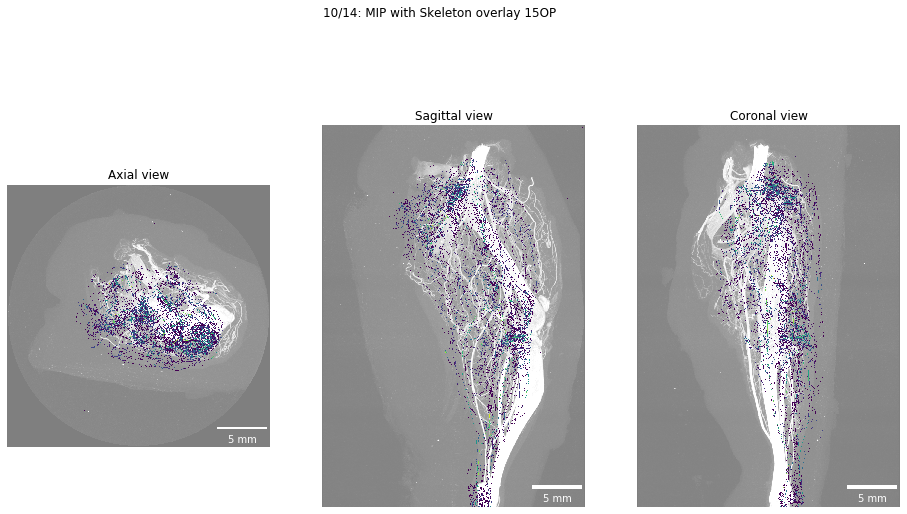

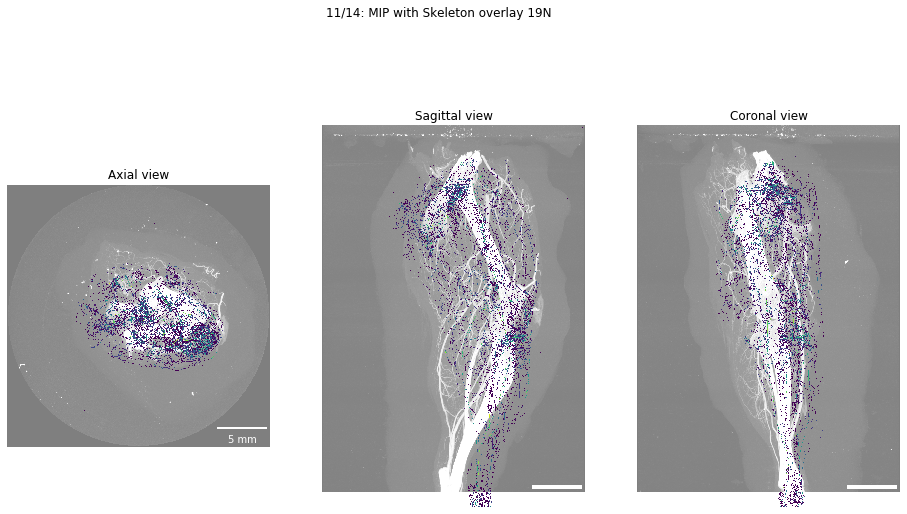

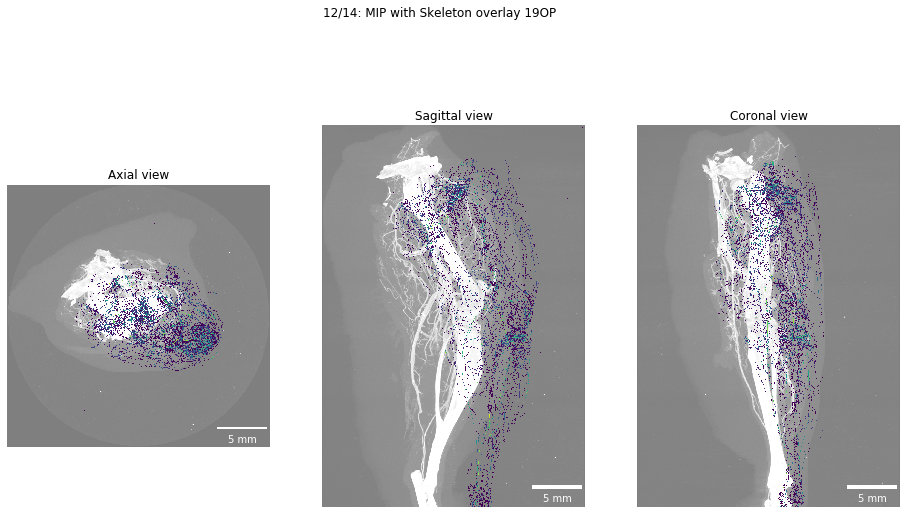

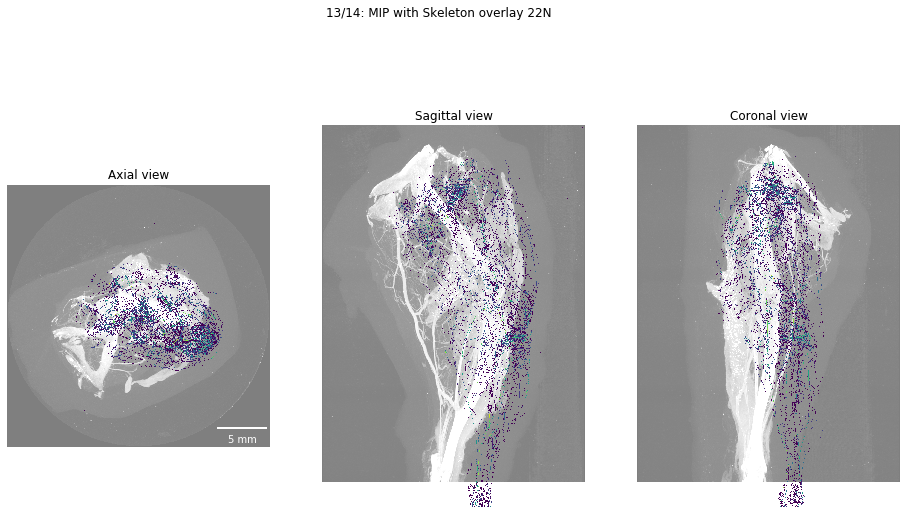

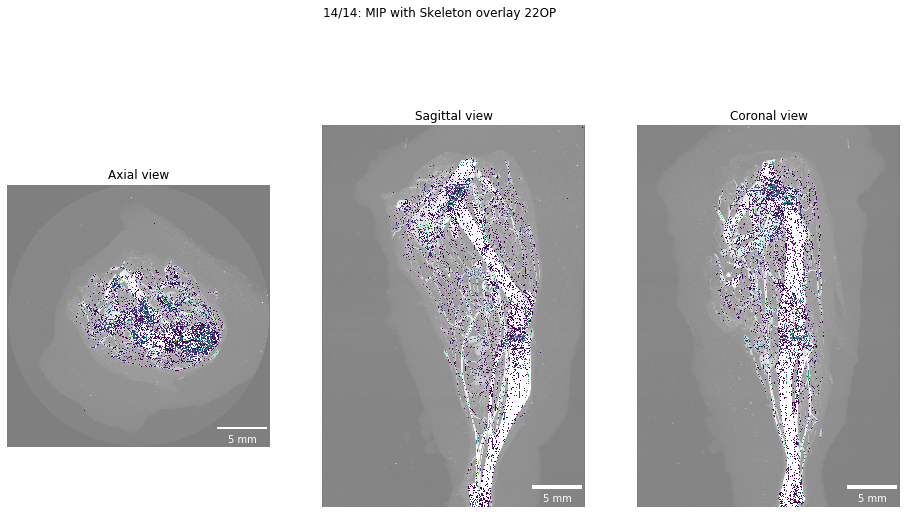

In [41]:
for i, row in Data.iterrows():
    for j, direction in enumerate(directions):
        plt.subplot(1,3,j+1)
        plt.imshow(row['MIP_' + direction], alpha=0.5)
        plt.imshow(numpy.ma.masked_less(numpy.max(SkelDist[c], axis=j),1), cmap='viridis')        
        plt.title('%s view' % direction)
        plt.gca().add_artist(ScaleBar(Data['Voxelsize'][c], 'um'))                
        plt.axis('off')        
    plt.suptitle('%02d/%02d: MIP with Skeleton overlay %s' % (i+1, len(Data), row['Sample']))
    plt.show()

In [42]:
Data['SkelDistMean'] = [numpy.mean(skldst) for skldst in SkelDist]

In [43]:
Data.head()

index                                        Folder Sample Experiment  \
0      0   /media/habi/Fast_SSD/Tuebingen/Overview/04N    04N          N   
1      1  /media/habi/Fast_SSD/Tuebingen/Overview/04OP   04OP         OP   
2      2   /media/habi/Fast_SSD/Tuebingen/Overview/07N    07N          N   
3      3  /media/habi/Fast_SSD/Tuebingen/Overview/07OP   07OP         OP   
4      4   /media/habi/Fast_SSD/Tuebingen/Overview/10N    10N          N   

   SampleNameLength                                            LogFile  \
0                 3  /media/habi/Fast_SSD/Tuebingen/Overview/04N/pr...   
1                 4  /media/habi/Fast_SSD/Tuebingen/Overview/04OP/p...   
2                 3  /media/habi/Fast_SSD/Tuebingen/Overview/07N/pr...   
3                 4  /media/habi/Fast_SSD/Tuebingen/Overview/07OP/p...   
4                 3  /media/habi/Fast_SSD/Tuebingen/Overview/10N/pr...   

   Voxelsize  NumRec                                    Reconstructions  \
0  21.603999    1767  [/media/habi/Fast_SSD/Tuebingen/Overview/04N/r...   
1  21.603999    1606  [/media/habi/Fast_SSD/Tuebingen/Overview/04OP/...   
2  21.603999    1598  [/media/habi/Fast_SSD/Tuebingen/Overview/07N/r...   
3  21.603999    1753  [/media/habi/Fast_SSD/Tuebingen/Overview/07OP/...   
4  21.603999    1948  [/media/habi/Fast_SSD/Tuebingen/Overview/10N/r...   

   Number of reconstructions  ... Threshold ThresholdMean  \
0                       1767  ...        98           103   
1                       1606  ...       101           103   
2                       1598  ...       106           103   
3                       1753  ...       101           103   
4                       1948  ...       108           103   

                               OutputNameThresholded ThresholdedVolume  \
0  /media/habi/Fast_SSD/Tuebingen/Overview/04N/04...           7650455   
1  /media/habi/Fast_SSD/Tuebingen/Overview/04OP/0...           7371814   
2  /media/habi/Fast_SSD/Tuebingen/Overview/07N/07...           6868607   
3  /media/habi/Fast_SSD/Tuebingen/Overview/07OP/0...           6868509   
4  /media/habi/Fast_SSD/Tuebingen/Overview/10N/10...           8943517   

                                   OutputNameFlooded  \
0  /media/habi/Fast_SSD/Tuebingen/Overview/04N/04...   
1  /media/habi/Fast_SSD/Tuebingen/Overview/04OP/0...   
2  /media/habi/Fast_SSD/Tuebingen/Overview/07N/07...   
3  /media/habi/Fast_SSD/Tuebingen/Overview/07OP/0...   
4  /media/habi/Fast_SSD/Tuebingen/Overview/10N/10...   

                                    OutputNameTophat  \
0  /media/habi/Fast_SSD/Tuebingen/Overview/04N/04...   
1  /media/habi/Fast_SSD/Tuebingen/Overview/04OP/0...   
2  /media/habi/Fast_SSD/Tuebingen/Overview/07N/07...   
3  /media/habi/Fast_SSD/Tuebingen/Overview/07OP/0...   
4  /media/habi/Fast_SSD/Tuebingen/Overview/10N/10...   

                                  OutputNameSkeleton  \
0  /media/habi/Fast_SSD/Tuebingen/Overview/04N/04...   
1  /media/habi/Fast_SSD/Tuebingen/Overview/04OP/0...   
2  /media/habi/Fast_SSD/Tuebingen/Overview/07N/07...   
3  /media/habi/Fast_SSD/Tuebingen/Overview/07OP/0...   
4  /media/habi/Fast_SSD/Tuebingen/Overview/10N/10...   

                                       OutputNameEDT  \
0  /media/habi/Fast_SSD/Tuebingen/Overview/04N/04...   
1  /media/habi/Fast_SSD/Tuebingen/Overview/04OP/0...   
2  /media/habi/Fast_SSD/Tuebingen/Overview/07N/07...   
3  /media/habi/Fast_SSD/Tuebingen/Overview/07OP/0...   
4  /media/habi/Fast_SSD/Tuebingen/Overview/10N/10...   

                                  OutputNameSkelDist  SkelDistMean  
0  /media/habi/Fast_SSD/Tuebingen/Overview/04N/04...      0.018710  
1  /media/habi/Fast_SSD/Tuebingen/Overview/04OP/0...      0.025608  
2  /media/habi/Fast_SSD/Tuebingen/Overview/07N/07...      0.017585  
3  /media/habi/Fast_SSD/Tuebingen/Overview/07OP/0...      0.018464  
4  /media/habi/Fast_SSD/Tuebingen/Overview/10N/10...      0.020239  

[5 rows x 30 columns]

In [44]:
Data['SkelDistMeanNormalized'] = [numpy.mean(skldst)/tv for skldst, tv in zip(SkelDist, Data['ThresholdedVolume'])]

In [45]:
Data['SkelDistSTD'] = [numpy.std(skldst) for skldst in SkelDist]

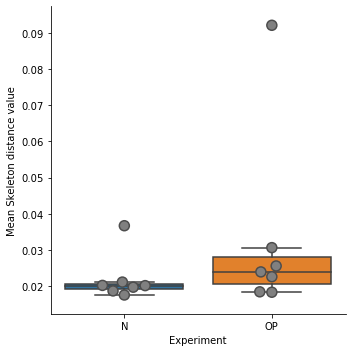

In [46]:
# Plot mean of datasets for comparison
seaborn.catplot(data=Data, kind='box', x='Experiment', y='SkelDistMean')
seaborn.swarmplot(data=Data, x='Experiment', y='SkelDistMean', linewidth=1.5, s=10, color='gray');
plt.ylabel('Mean Skeleton distance value')
# plt.ylim(ymin=0)
plt.show()

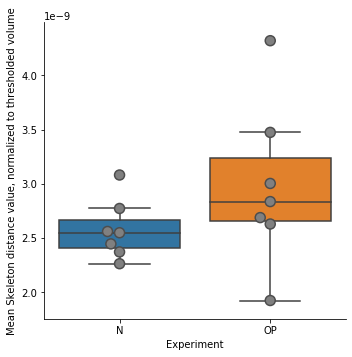

In [47]:
# Plot mean of datasets for comparison
seaborn.catplot(data=Data, kind='box', x='Experiment', y='SkelDistMeanNormalized')
seaborn.swarmplot(data=Data, x='Experiment', y='SkelDistMeanNormalized', linewidth=1.5, s=10, color='gray');
plt.ylabel('Mean Skeleton distance value, normalized to thresholded volume')
# plt.ylim(ymin=0)
plt.show()

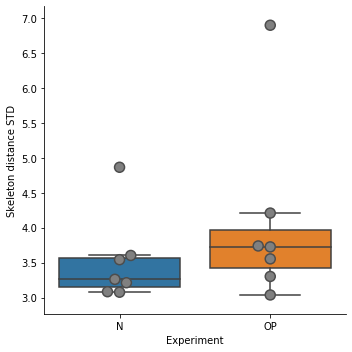

In [48]:
# Plot STD of datasets for comparison
seaborn.catplot(data=Data, kind='box', x='Experiment', y='SkelDistSTD')
seaborn.swarmplot(data=Data, x='Experiment', y='SkelDistSTD', linewidth=1.5, s=10, color='gray');
plt.ylabel('Skeleton distance STD')
# plt.ylim(ymin=0)
plt.show()

In [49]:
asdfasdfasdfa===

SyntaxError: invalid syntax (<ipython-input-49-2a511b9394ba>, line 1)

In [ ]:
for i in Data:
    print(i)

In [ ]:
for i in Data:
    print(i)

In [ ]:
plt.hist(skeleton.ravel(), bins=64, log=True)
plt.show()

In [ ]:
numpy.shape(skeleton)

In [ ]:
whichslice=55
plt.subplot(221)
plt.imshow(img[whichslice,:,:])
plt.title('Original')
plt.subplot(222)
plt.imshow(thresh[whichslice,:,:])
plt.imshow(tophat[whichslice,:,:], cmap='viridis', alpha=0.5)
plt.title('Thresholded with input for skeletonization (tophat: yellow)')
plt.subplot(223)
plt.imshow(tophat[whichslice,:,:])
plt.imshow(skeleton[whichslice,:,:], cmap='viridis', alpha=0.5)
plt.title('Input for skeletonization (purple) with skeleton (yellow)')
plt.subplot(224)
plt.imshow(skeleton[whichslice,:,:])
plt.show()

In [ ]:
plt.imshow(numpy.max(skeleton, axis=2))
plt.show()

In [ ]:
asdfasdf==skeleton

In [ ]:
import numpy as np
from scipy import ndimage as ndi
from skimage.morphology import medial_axis
import matplotlib.pyplot as plt


def microstructure(l=256):
    """
    Synthetic binary data: binary microstructure with blobs.

    Parameters
    ----------

    l: int, optional
        linear size of the returned image

    """
    n = 5
    x, y = np.ogrid[0:l, 0:l]
    mask = np.zeros((l, l))
    generator = np.random.RandomState(1)
    points = l * generator.rand(2, n**2)
    mask[(points[0]).astype(np.int), (points[1]).astype(np.int)] = 1
    mask = ndi.gaussian_filter(mask, sigma=l/(4.*n))
    return mask > mask.mean()

data = microstructure(l=64)

# Compute the medial axis (skeleton) and the distance transform
skel, distance = medial_axis(data, return_distance=True)

# Distance to the background for pixels of the skeleton
dist_on_skel = distance * skel

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)
ax1.imshow(data)
ax1.axis('off')
ax2.imshow(dist_on_skel, cmap='viridis')
ax2.contour(data, [0.5], colors='w')
ax2.axis('off')

fig.tight_layout()
plt.show()

In [ ]:
BW = thresh[50,:,:]
plt.imshow(BW)
plt.show()

In [ ]:
# BW = 1 - BW
M,N = BW.shape
'''Calculating Euclidean Distance of the Binary Image'''
D,IDX = morph.distance_transform_edt(BW,return_distances=True, return_indices=True)
D = mat2gray(D)
X,Y = np.meshgrid(range(N),range(M))
delD_x = -(IDX[1,:,:] - X)
delD_y = -(IDX[0,:,:] - Y)
# normalize the derivatives
delD_norm = np.sqrt(pow(delD_x,2) + pow(delD_y,2))
with np.errstate(divide='ignore',invalid='ignore'):
    delD_xn   = delD_x / delD_norm
    delD_yn   = delD_y / delD_norm

mir_delD_xn  = mirrorBW(delD_xn)
mir_delD_yn  = mirrorBW(delD_yn)

f, (ax1, ax2,ax3) = plt.subplots(1,3,figsize=(10,30))
ax1.imshow(D)
ax1.set_title('Euclidean Distance Transform')
ax2.imshow(delD_x)
ax2.set_title('X direction of the gradient of EDT')
ax3.imshow(delD_y)
ax3.set_title('Y direction of the gradient of EDT')
plt.tight_layout()
plt.show()

In [ ]:
#Calculate flux map
fluxMap = flux(mir_delD_xn,mir_delD_yn)
plt.imshow(np.nan_to_num(fluxMap))
plt.title('Flux Map')
plt.show()

In [ ]:
#Calculate flux map
fluxMap = flux(mir_delD_xn,mir_delD_yn)
# Calculate flux threshold
fluxBWThreshold = (np.nanmax(fluxMap) - np.nanmean(fluxMap)) * 0.15 + np.nanmean(fluxMap)
with np.errstate(divide='ignore',invalid='ignore'):
    fluxThin = thin(fluxMap>fluxBWThreshold)

fluxLabeled,b = ndimage.label(fluxThin, np.array([[1,1,1], [1,1,1], [1,1,1]]))
labels ,pixelSize = np.unique(fluxLabeled,return_counts=True)
# Excluding the background
pixelSize = pixelSize[labels != 0]
labels = labels[labels != 0]
# Calculating the size threshold and filter out small objects
th = min(np.mean(pixelSize) + 3 * np.std(pixelSize), np.max(pixelSize))
selectedObjects = labels[np.where(pixelSize >= th)]

fluxTemp = np.zeros(fluxMap.shape)
fluxTemp[fluxLabeled == 1] = 1
plt.imshow(fluxTemp,cmap='gray')
plt.title('Initial Skeleton with branches')
plt.tight_layout()
plt.show()

In [ ]:
viewer = napari.view_image(data.moon())

In [ ]:
asdfasdf==

Try to filter out the vessels with a [`Frangi` vesselness filter](https://scikit-image.org/docs/dev/api/skimage.filters.html#skimage.filters.frangi).
It is *slow*!

In [ ]:
shift = 200
crop = Reconstructions[9][700:-700,350+shift:-350+shift,350+shift:-350+shift]

In [ ]:
numpy.shape(crop)

In [ ]:
vessels = skimage.filters.frangi(crop)

In [ ]:
view((vessels*100000).astype('uint8'))

In [ ]:
numpy.shape(vessels)

In [ ]:
numpy.shape(crop)

In [ ]:
numpy.max(vessels*1000)

In [ ]:
plt.subplot(121)
plt.imshow(numpy.max(crop, axis=1))
plt.subplot(122)
plt.imshow(numpy.max(vessels, axis=1), vmax=1e-5)

In [ ]:
import numpy
numpy.ones((5,5))

In [ ]:
a = numpy.reshape(numpy.arange(25), (5,5))

In [ ]:
a

In [ ]:
numpy.clip(a,5,13)

In [ ]:
plt.imshow(a)